In [ ]:
#Sets up Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#installing the kaggle library
!pip install -q kaggle

In [ ]:
# downloading dataset using kaggle API
!kaggle datasets download -d henriqueyamahata/bank-marketing

Dataset URL: https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing
License(s): other
  0% 0.00/393k [00:00<?, ?B/s]
100% 393k/393k [00:00<00:00, 954MB/s]


In [ ]:
#unzipping the dataset
!unzip bank-marketing.zip

Archive:  bank-marketing.zip
  inflating: bank-additional-full.csv  
  inflating: bank-additional-names.txt  


In [ ]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report,confusion_matrix,f1_score


In [ ]:
#reading the bank marketing dataset and displaying the first 5 values
df = pd.read_csv('/content/bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
#genereal info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
#Checks the total number of missing values
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [ ]:
# total rows and column in the dataset
df.shape

(41188, 21)

#Explolatory data analysis

In [ ]:
df.isnull().sum()
df.apply(lambda x: (x == 'unknown').sum())  # hidden missing values

,0
age,0
job,330
marital,80
education,1731
default,8597
housing,990
loan,990
contact,0
month,0
day_of_week,0


In [ ]:
# I will replace the unknown values with mode
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'poutcome']

for col in categorical_cols:
    df[col] = df[col].replace('unknown', df[col].mode()[0])


####Some columns contain hidden missing values labeled as ‘unknown’. I replaced them with the most frequent value (mode) in each column.

In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
# Let's varify whether we have any missing values of not
df.isnull().sum()
df.apply(lambda x: (x == 'unknown').sum())

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [ ]:
#Summary statistics
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [ ]:
#Creates a reusable pie chart function to visualize category proportions for any column
def pie_plot(col, title="Pie Chart"):
    plt.figure(figsize=(6,6))
    value_counts = df[col].value_counts()
    labels = value_counts.index
    values = value_counts.values
    colors = sns.color_palette('pastel')[:len(labels)]
    plt.pie(values, labels=labels, autopct='%.1f%%', startangle=140, colors=colors, explode=[0.03]*len(labels))
    plt.title(title)
    plt.show()


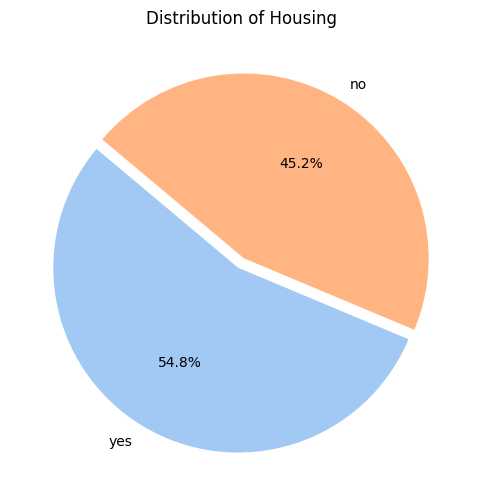

In [ ]:
# Plots a pie chart showing the proportion of customers with or without a housing loan
pie_plot('housing', title='Distribution of Housing')

####The pie chart shows the distribution of customers based on their housing loan status. About 54.8% of customers have a housing loan, while 45.2% do not.

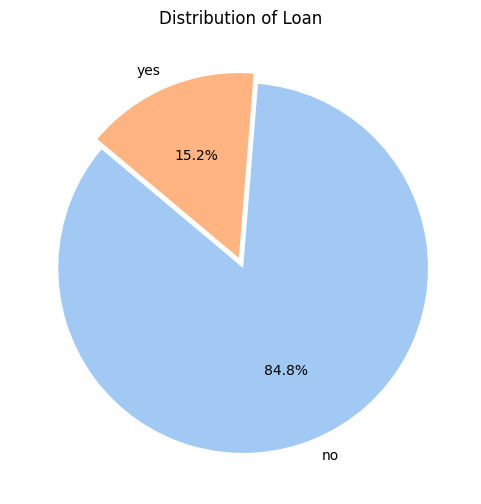

In [ ]:
# Plots a pie chart showing the proportion of customers with or without a personal loan
pie_plot('loan', title='Distribution of Loan')

Most customers don’t have a personal loan  around 85%, in fact.
Only a small share, about 15%, are currently paying one off.

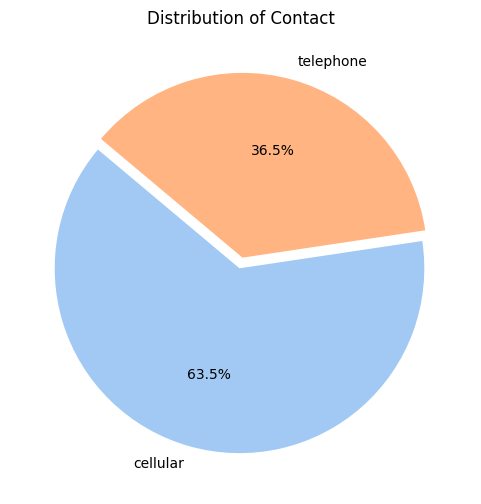

In [ ]:
# Plots a pie chart showing the proportion of customers with or without a contract
pie_plot('contact', title='Distribution of Contact')

Most customers were contacted through cellular phones (63.5%), while 36.5% were reached via landline.
It shows that mobile communication was the primary channel for the bank’s marketing campaigns.

In [ ]:
# Defines a reusable function to plot count plots for categorical columns
def count_plot(col, title="Count Plot"):
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, data=df, palette='pastel', order=df[col].value_counts().index)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

/tmp/ipython-input-2897862642.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='pastel', order=df[col].value_counts().index)


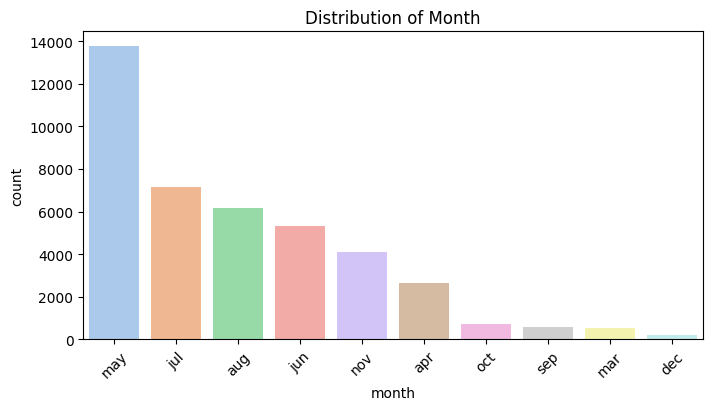

In [ ]:
# Plots a count chart showing the number of marketing contacts made each month
count_plot('month', title='Distribution of Month')

Most marketing calls were made in May, followed by July and August, while months like December and March had very few.

/tmp/ipython-input-2897862642.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='pastel', order=df[col].value_counts().index)


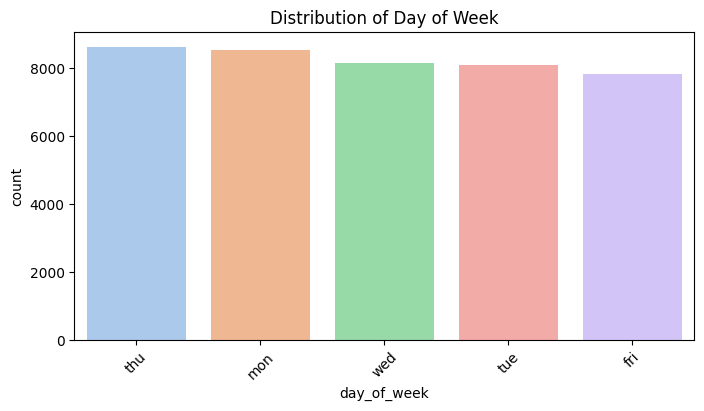

In [ ]:
# Plots a count chart showing the number of marketing contacts made on each day of the week
count_plot('day_of_week', title='Distribution of Day of Week')

/tmp/ipython-input-2897862642.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='pastel', order=df[col].value_counts().index)


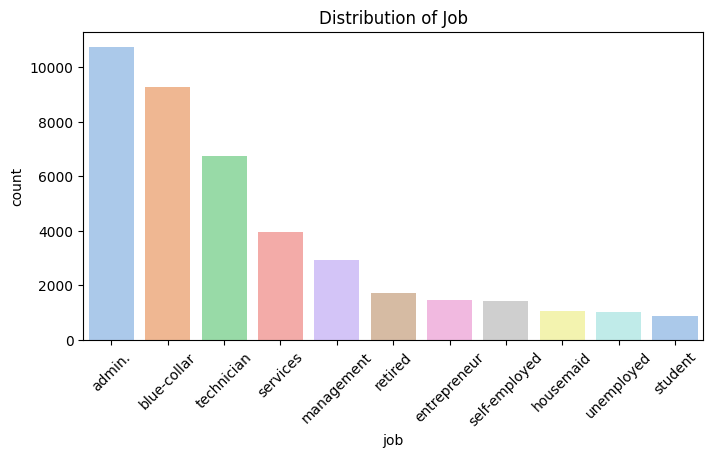

In [ ]:
# Plots a count chart showing the number of customers in each job category
count_plot('job', 'Distribution of Job')

Most customers work in administrative and blue-collar jobs, followed by technicians and service roles.
Fewer customers come from management, student, or unemployed groups, showing the dataset is dominated by working professionals.

/tmp/ipython-input-2897862642.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='pastel', order=df[col].value_counts().index)


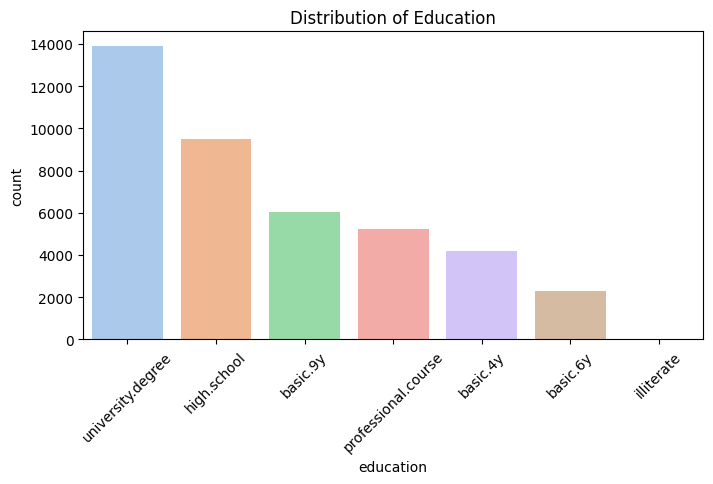

In [ ]:
# Plots a count chart showing the number of customers by education level
count_plot('education', 'Distribution of Education')

Most customers hold a university degree or high school education, while a smaller portion completed only basic education.
This suggests the bank’s customer base is largely well-educated, which could influence financial awareness and decision-making.

/tmp/ipython-input-2897862642.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='pastel', order=df[col].value_counts().index)


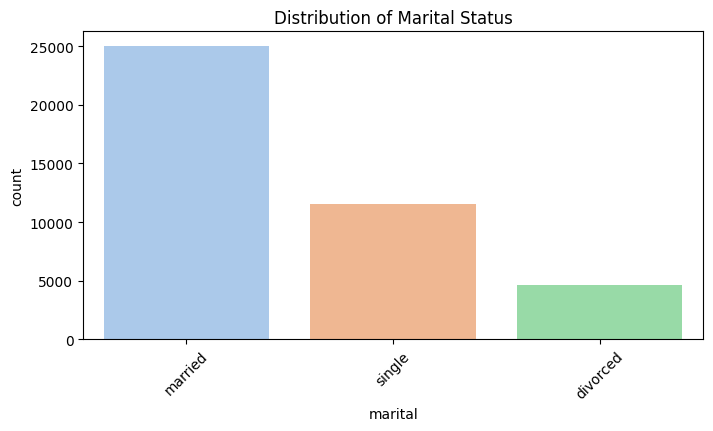

In [ ]:
# Plots a count chart showing the number of customers by marital status
count_plot('marital', 'Distribution of Marital Status')

Most customers are married, followed by single individuals, while the divorced group is much smaller.
This shows that married people form the majority of the bank’s client base.

In [ ]:
# Defines a function to visualize the subscription (success) rate for each category in a given column
def pos_rate_plot(col, title="Subscription Rate by Category"):
    plt.figure(figsize=(8,4))
    rate = df.groupby(col)['y'].apply(lambda x: (x=='yes').mean()).sort_values(ascending=False)
    sns.barplot(x=rate.index, y=rate.values, palette='coolwarm')
    plt.title(title)
    plt.ylabel('Proportion of Yes (%)')
    plt.xticks(rotation=45)
    plt.show()

/tmp/ipython-input-49422464.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rate.index, y=rate.values, palette='coolwarm')


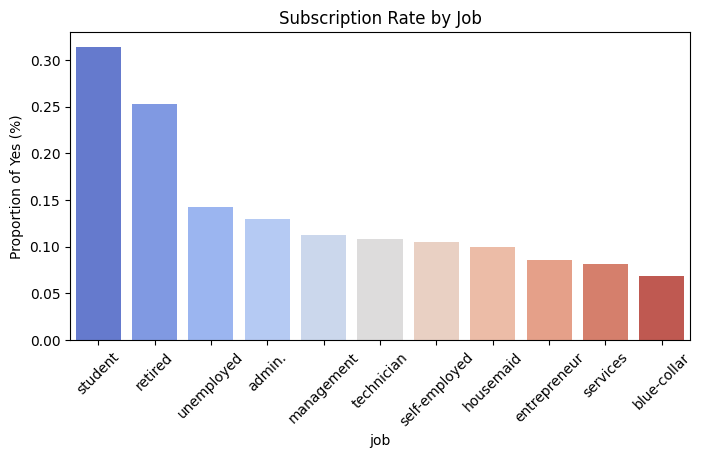

In [ ]:
# Plots the subscription success rate for each job category
pos_rate_plot('job', 'Subscription Rate by Job')

Students and retired customers have the highest subscription rates, while blue-collar and service workers show the lowest.
This suggests that individuals with more free time or financial security are more likely to subscribe to the bank’s offers.

/tmp/ipython-input-49422464.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rate.index, y=rate.values, palette='coolwarm')


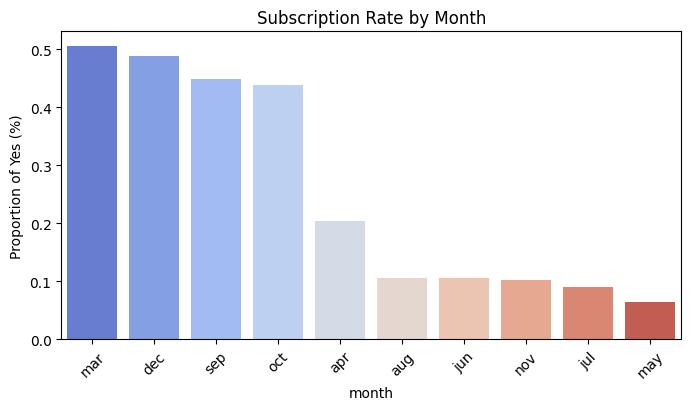

In [ ]:
# Plots the subscription success rate for each month of marketing campaigns

pos_rate_plot('month', 'Subscription Rate by Month')

Subscription rates were highest in March, December, and September, and much lower during mid-year months like May and July.
This suggests that timing plays a big role  customers were more responsive to campaigns during the year-end and early months.

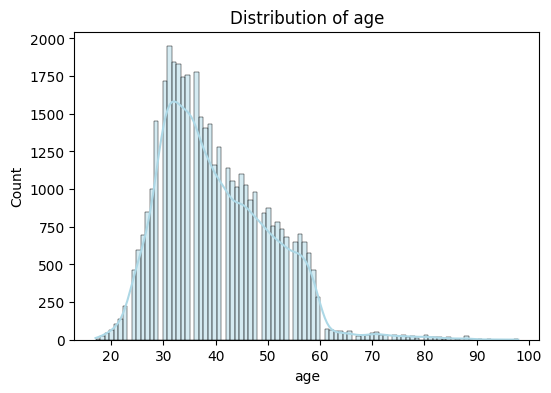

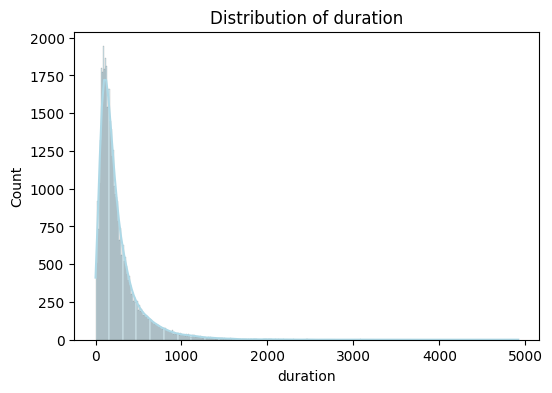

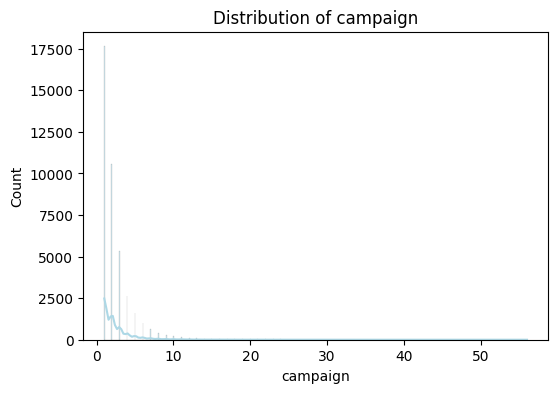

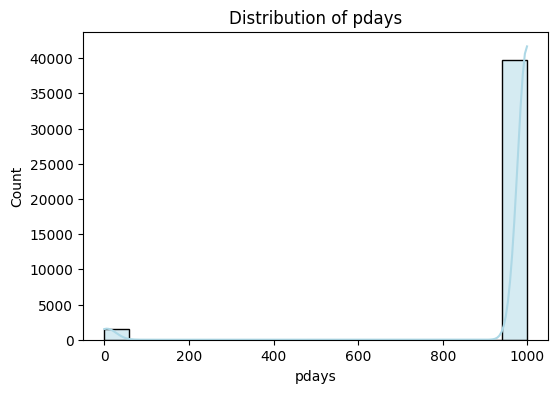

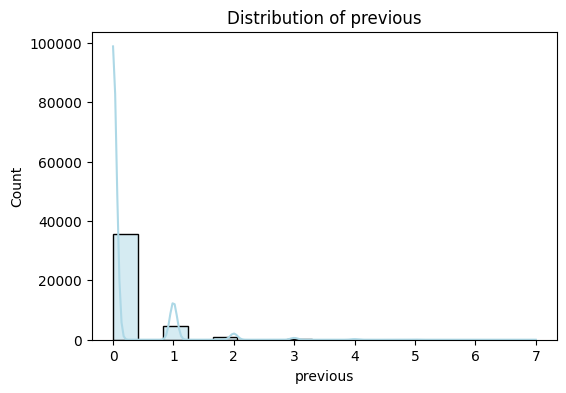

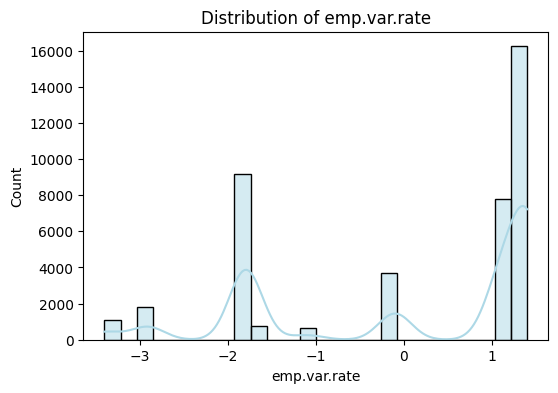

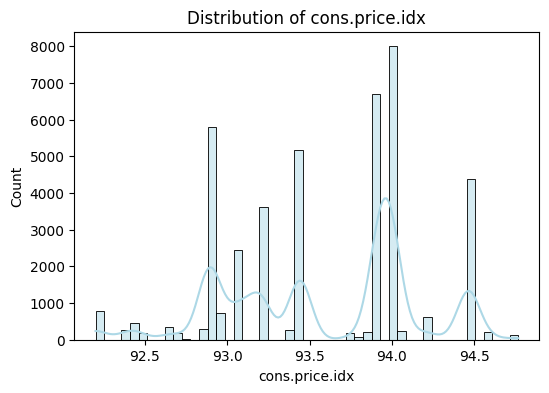

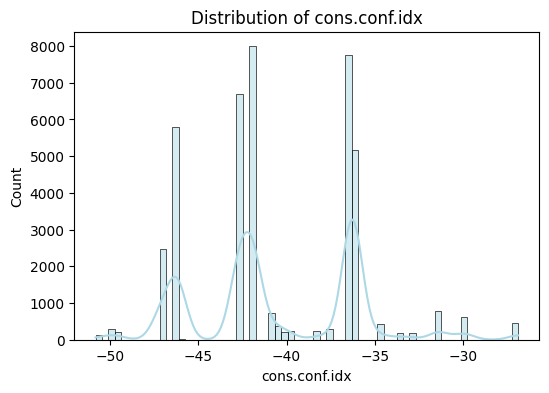

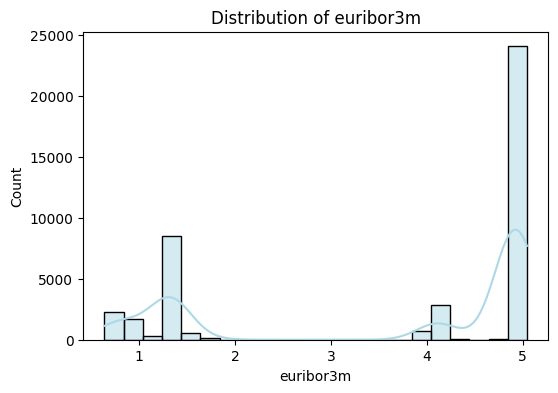

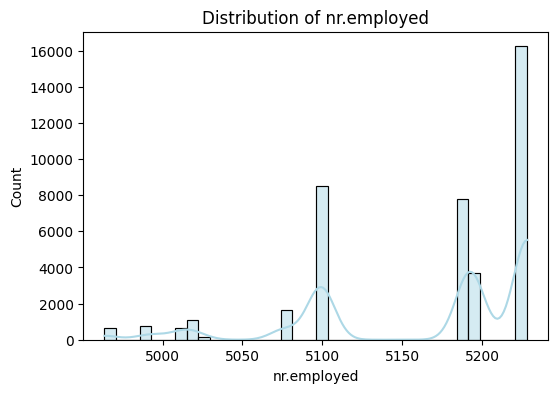

In [ ]:
# Plots histograms with density curves for all numerical columns to show their distributions

num_cols = df.select_dtypes(include=['int64','float64']).columns

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, color='lightblue')
    plt.title(f"Distribution of {col}")
    plt.show()


/tmp/ipython-input-1755439471.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=col, data=df, palette='Set2')


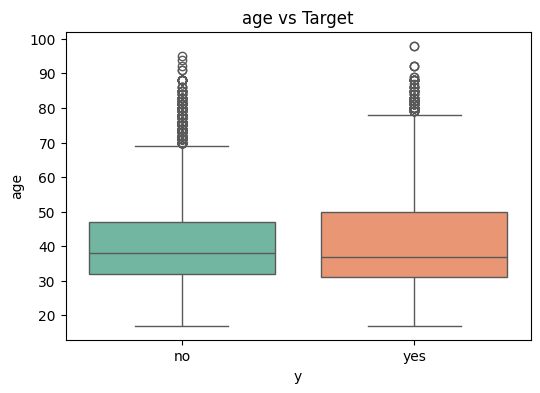

/tmp/ipython-input-1755439471.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=col, data=df, palette='Set2')


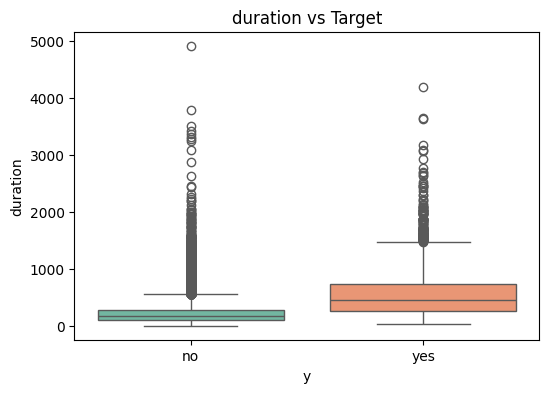

/tmp/ipython-input-1755439471.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=col, data=df, palette='Set2')


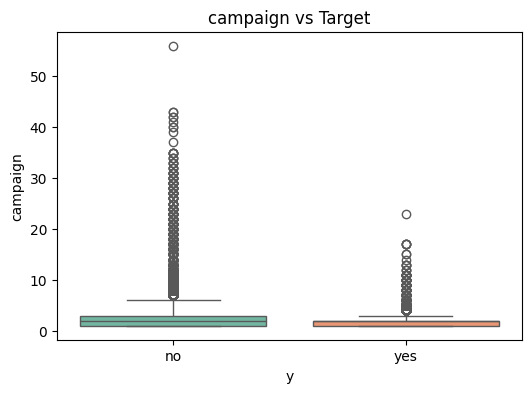

/tmp/ipython-input-1755439471.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=col, data=df, palette='Set2')


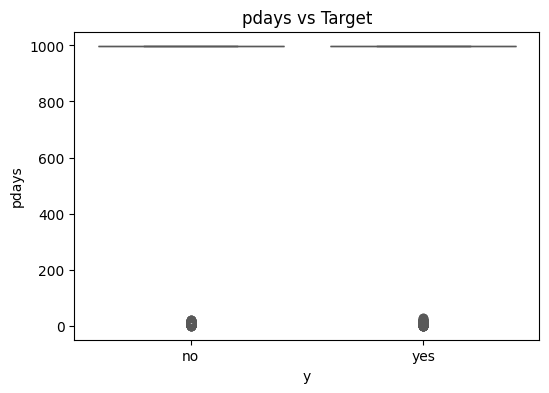

/tmp/ipython-input-1755439471.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=col, data=df, palette='Set2')


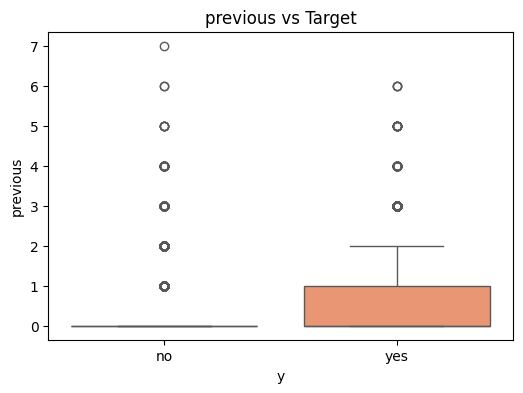

/tmp/ipython-input-1755439471.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=col, data=df, palette='Set2')


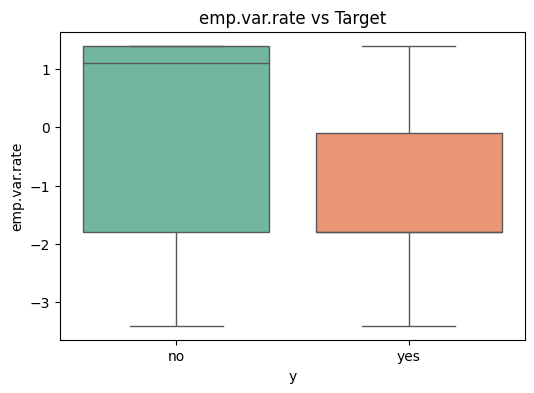

/tmp/ipython-input-1755439471.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=col, data=df, palette='Set2')


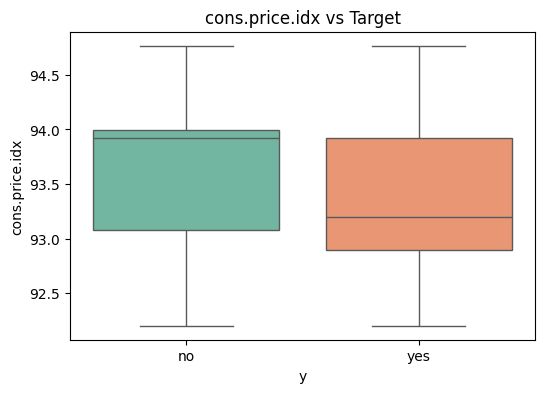

/tmp/ipython-input-1755439471.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=col, data=df, palette='Set2')


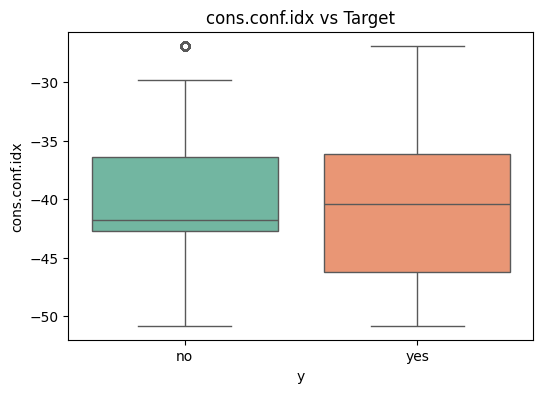

/tmp/ipython-input-1755439471.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=col, data=df, palette='Set2')


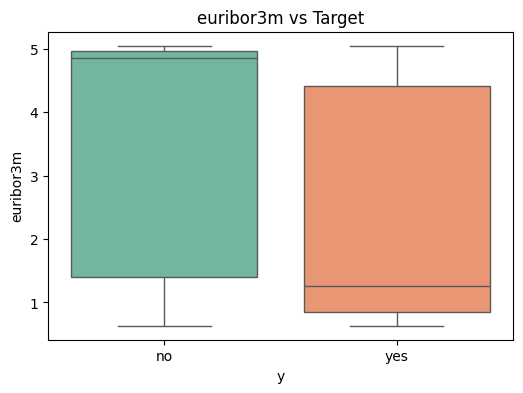

/tmp/ipython-input-1755439471.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=col, data=df, palette='Set2')


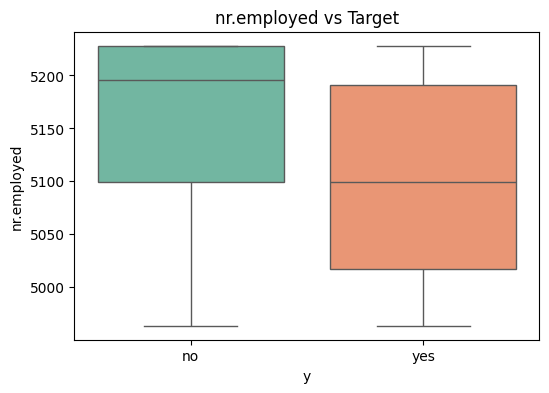

In [ ]:
# Plots boxplots to compare the distribution of each numeric feature against the target variable 'y'
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='y', y=col, data=df, palette='Set2')
    plt.title(f"{col} vs Target")
    plt.show()


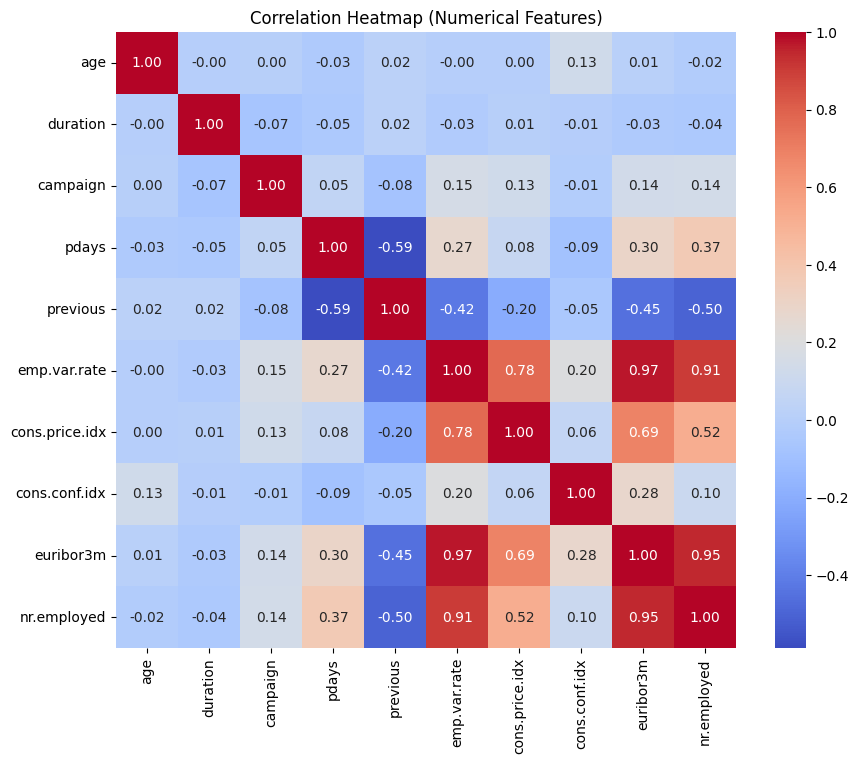

In [ ]:
# Correlation heatmap of all the numerical features
plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

Only these three variables — euribor3m, nr.employed, and emp.var.rate  were highly correlated with each other. Once I dropped the first two, the multicollinearity issue was basically gone.
I decided to keep emp.var.rate because it gives a clearer picture of how employment conditions change over time, which directly influences people’s financial decisions. The other two variables reflect similar economic patterns but in a less direct way, so keeping just this one keeps the model simpler without losing any important information.

#Data engineering

In [ ]:
#Let's drop highly corelated numerical columns
df = df.drop(columns=['euribor3m', 'nr.employed'], errors='ignore')

In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,no
1,57,services,married,high.school,no,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,no


In [ ]:
df.shape

(41188, 19)

In [ ]:
# map 'yes'/'no' to 1/0 for the target
y = df["y"].map({"no": 0, "yes": 1}).astype(int)

# remove target from features
X = df.drop(columns=["y"])


In [ ]:
#Apply one-hot encoding to categorical columns to convert them into numerical form for model learning

from sklearn.preprocessing import OneHotEncoder
# find categorical columns in X
cat_cols = X.select_dtypes(include="object").columns.tolist()

# One Hot encoding
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_ohe = pd.DataFrame(
    ohe.fit_transform(X[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=X.index
)

# keep numeric columns as-is
num_cols = X.select_dtypes(exclude="object").columns.tolist()

# final all-numeric feature frame
X_final = pd.concat([X[num_cols], X_ohe], axis=1)


In [ ]:
X_final.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,job_admin.,job_blue-collar,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,149,1,999,0,1.1,93.994,-36.4,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,226,1,999,0,1.1,93.994,-36.4,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,151,1,999,0,1.1,93.994,-36.4,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,307,1,999,0,1.1,93.994,-36.4,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
X_final.shape

(41188, 55)

## Train test Split

In [ ]:
# Splits the dataset into training and testing sets for model evaluation


X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify = y
)

#Decision Tree Classifier

####Using GridSearchCV to find the best hyperparameters and improve model accuracy through cross-validation

In [ ]:
# Define parameter grid for tuning
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_dt = grid_search.best_estimator_

# Evaluate on training data
y_train_pred = best_dt.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc * 100:.2f}%")

# Evaluate on testing data
y_test_pred = best_dt.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_acc * 100:.2f}%")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training Accuracy: 91.36%
Testing Accuracy: 91.55%
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      7310
           1       0.69      0.45      0.55       928

    accuracy                           0.92      8238
   macro avg       0.81      0.71      0.75      8238
weighted avg       0.91      0.92      0.91      8238



#  Random Forest Classifier

In [ ]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_rf = grid_search.best_estimator_

# Evaluate on training data
y_train_pred = best_rf.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc * 100:.2f}%")

# Evaluate on testing data
y_test_pred = best_rf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_acc * 100:.2f}%")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training Accuracy: 95.34%
Testing Accuracy: 91.58%
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.73      0.40      0.52       928

    accuracy                           0.92      8238
   macro avg       0.83      0.69      0.74      8238
weighted avg       0.91      0.92      0.90      8238



#  XGBoost Classifier

In [ ]:
 #  XGBoost Classifier

param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# Initialize XGBoost Classifier
xgb = XGBClassifier(random_state=2)

# Perform Grid Search with 5-fold cross-validation
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

# Get the best model and parameters
best_params_xgb = grid_search_xgb.best_params_
print("Best Hyperparameters:", best_params_xgb)

best_xgb = grid_search_xgb.best_estimator_

# Evaluate on training data
y_train_pred_xgb = best_xgb.predict(X_train)
train_acc_xgb = accuracy_score(y_train, y_train_pred_xgb)
print(f"Training Accuracy: {train_acc_xgb * 100:.2f}%")

# Evaluate on testing data
y_test_pred_xgb = best_xgb.predict(X_test)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
print(f"Testing Accuracy: {test_acc_xgb * 100:.2f}%")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_test_pred_xgb))

Best Hyperparameters: {'gamma': 0.3, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 150}
Training Accuracy: 92.27%
Testing Accuracy: 92.17%
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      7310
           1       0.69      0.55      0.61       928

    accuracy                           0.92      8238
   macro avg       0.82      0.76      0.78      8238
weighted avg       0.92      0.92      0.92      8238



### Among Decision Tree, Random Forest, and XGBoost, Random Forest performed the best with 91.58% test accuracy and well-balanced precision and recall. This makes it the most reliable model for our task.

### Now, I’ll use this trained Random Forest model to create a pipeline and integrate it into a Flask app for deployment.

### Final Model Preparation: Random Forest Pipeline for Flask Deployment

In [ ]:
# rebuild final model as a Pipeline so Flask can just call predict()
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# rebuild from RAW data so OHE fits on original categoricals
df_raw = pd.read_csv("bank-additional-full.csv", sep=";")
df_raw = df_raw.drop(columns=["euribor3m", "nr.employed"], errors="ignore")
y_raw = df_raw["y"].map({"no":0, "yes":1}).astype(int)
X_raw = df_raw.drop(columns=["y"])

cat_cols_raw = X_raw.select_dtypes(include="object").columns.tolist()
num_cols_raw = X_raw.select_dtypes(exclude="object").columns.tolist()


In [ ]:
#Create a ColumnTransformer to apply One-Hot Encoding on categorical columns and pass numeric columns unchanged
pre = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_raw),
     ("num", "passthrough", num_cols_raw)]
)

In [ ]:
#Build a pipeline that first applies preprocessing and then trains the Random Forest model with the best hyperparameters
final_pipe = Pipeline([
    ("pre", pre),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

In [ ]:
#Fit the full pipeline on the entire dataset so it learns both preprocessing and the final Random Forest model together
final_pipe.fit(X_raw, y_raw)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome']),
                                                 ('num', 'passthrough',
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx'])])),
                ('model',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=200,
                                        n_jobs=-1, random_state=42))])

In [ ]:
#Save the trained pipeline as a .joblib file to load later in the Flask app for making predictions
joblib.dump(final_pipe, "model.joblib")
print("Saved! Pipeline ready for predictions ")

Saved! Pipeline ready for predictions 


#                             Thank you
